In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [5]:
im_wid = 128
im_hei = 128
ids = next(os.walk("ground_truth"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))
print(ids)

No. of images =  2594
['ISIC_0000075.jpg', 'ISIC_0014763.jpg', 'ISIC_0001204.jpg', 'ISIC_0014782.jpg', 'ISIC_0011166.jpg', 'ISIC_0000529.jpg', 'ISIC_0000330.jpg', 'ISIC_0000176.jpg', 'ISIC_0004715.jpg', 'ISIC_0012898.jpg', 'ISIC_0002093.jpg', 'ISIC_0014317.jpg', 'ISIC_0000546.jpg', 'ISIC_0014772.jpg', 'ISIC_0000249.jpg', 'ISIC_0000069.jpg', 'ISIC_0010081.jpg', 'ISIC_0000049.jpg', 'ISIC_0012656.jpg', 'ISIC_0001131.jpg', 'ISIC_0012338.jpg', 'ISIC_0015973.jpg', 'ISIC_0012956.jpg', 'ISIC_0009891.jpg', 'ISIC_0012852.jpg', 'ISIC_0000320.jpg', 'ISIC_0000274.jpg', 'ISIC_0015008.jpg', 'ISIC_0009895.jpg', 'ISIC_0014897.jpg', 'ISIC_0000388.jpg', 'ISIC_0009879.jpg', 'ISIC_0012735.jpg', 'ISIC_0010005.jpg', 'ISIC_0014386.jpg', 'ISIC_0010201.jpg', 'ISIC_0013518.jpg', 'ISIC_0010588.jpg', 'ISIC_0010322.jpg', 'ISIC_0014503.jpg', 'ISIC_0010227.jpg', 'ISIC_0014663.jpg', 'ISIC_0000245.jpg', 'ISIC_0000511.jpg', 'ISIC_0010479.jpg', 'ISIC_0013052.jpg', 'ISIC_0003559.jpg', 'ISIC_0013526.jpg', 'ISIC_0013739.jpg

In [4]:
x = np.zeros((len(ids), im_wid, im_hei, 1), dtype= np.float32)
y = np.zeros((len(ids), im_wid, im_hei, 1), dtype= np.float32)

In [6]:
for n, ide in tqdm_notebook(enumerate(ids), total=len(ids)):
    img = load_img("train_input/"+ide, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (512, 512, 1), mode = 'constant', preserve_range = True)
    mask = img_to_array(load_img("ground_truth/"+ide, grayscale=True))
    mask = resize(mask, (512, 512, 1), mode = 'constant', preserve_range = True)
    x[n] = x_img/255.0
    y[n] = mask/255.0

/home/xia/miniconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_val = x_train[-300:]
y_val = y_train[-300:]
x_train = x_train[:-300]
y_train = y_train[:-300]

print(len(x))
print(len(y))
print(len(x_val))
print(len(y_val))
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))


2594
2594
300
300
1775
1775
519
519


162


Text(0.5, 1.0, 'mask')

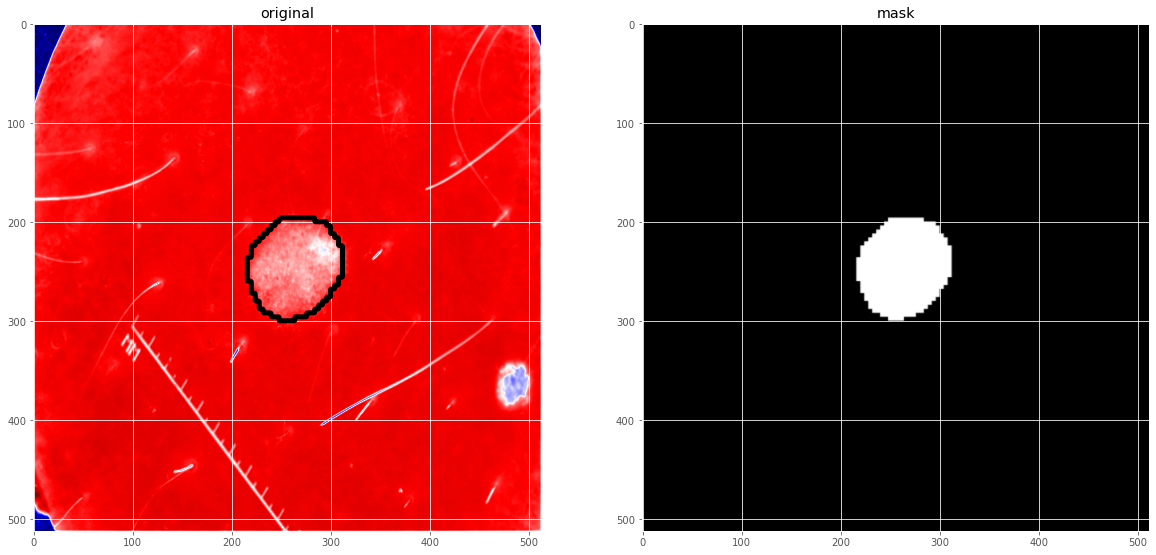

In [15]:
ix = random.randint(0, len(x_train))
print(ix)
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(x_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('original')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('mask')

In [16]:

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):

    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model


In [17]:

input_img = Input((im_hei, im_wid, 1), name='img')
input_img.shape


TensorShape([None, 512, 512, 1])

In [18]:
model = get_unet(input_img, n_filters=16, dropout=0.05)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 512, 512, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 512, 512, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [3]:
filepath = "cancer_segmentation.hdf5"

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath,monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)
]

NameError: name 'EarlyStopping' is not defined

In [ ]:
result = model.fit(x_train, y_train, batch_size=35, epochs=25, callbacks=callbacks,\
                    validation_data=(x_val, y_val))

Train on 1775 samples, validate on 300 samples
Epoch 1/25


In [201]:
from keras.models import load_model
model = load_model("cancer_segmentation.hdf5")
print(model)

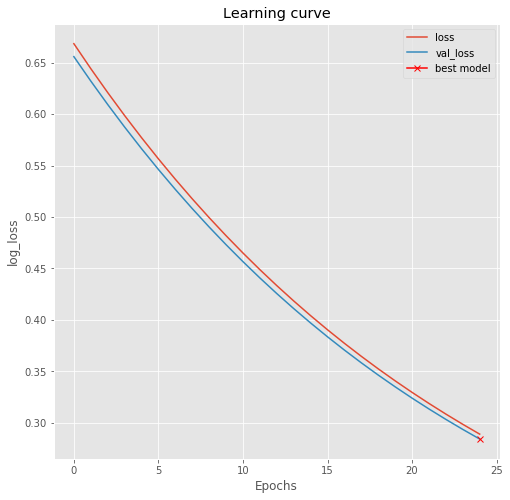

In [206]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(result.history["loss"], label="loss")
plt.plot(result.history["val_loss"], label="val_loss")
plt.plot( np.argmin(result.history["val_loss"]), np.min(result.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [207]:
model.load_weights('cancer_segmentation.hdf5')

In [209]:
model.evaluate(x_test,y_test,verbose=1)

519/519 [==============================] - 21s 40ms/step


[0.6807296364523312, 1.0]

In [210]:
preds_train = model.predict(x_train, verbose=1)
preds_test = model.predict(x_test, verbose=1)

519/519 [==============================] - 19s 37ms/step


In [211]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [223]:
def plot_sample(x, y, preds, binary_preds, ix=None):

    if ix is None:
        ix = random.randint(0, len(x))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(x[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Orig')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

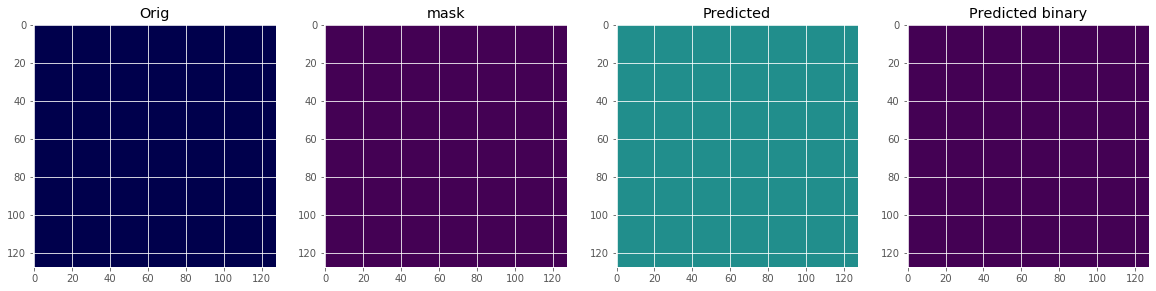

In [225]:

plot_sample(x, y, preds_train, preds_train_t)